###Compare three types of momentum
    
    1. batch SGD
    2. batch SGD with momentum
    3. batch SGD with Nesterov momentum

In [0]:
import os
os.chdir('/content/drive/My Drive/Colab Notebooks/Lazy courses/DS:Deep Learning in Python/Digit Recognizer')

Reading in and transforming data
Cost at iteration i=0, j=0: 2355.867582
Error rate: 0.891
Cost at iteration i=0, j=50: 962.075883
Error rate: 0.212
Cost at iteration i=1, j=0: 728.996960
Error rate: 0.166
Cost at iteration i=1, j=50: 565.507976
Error rate: 0.138
Cost at iteration i=2, j=0: 506.338032
Error rate: 0.124
Cost at iteration i=2, j=50: 447.842013
Error rate: 0.116
Cost at iteration i=3, j=0: 420.633092
Error rate: 0.113
Cost at iteration i=3, j=50: 389.481403
Error rate: 0.106
Cost at iteration i=4, j=0: 373.542562
Error rate: 0.106
Cost at iteration i=4, j=50: 353.534061
Error rate: 0.099
Cost at iteration i=5, j=0: 342.872954
Error rate: 0.097
Cost at iteration i=5, j=50: 328.610947
Error rate: 0.093
Cost at iteration i=6, j=0: 320.834357
Error rate: 0.092
Cost at iteration i=6, j=50: 309.895249
Error rate: 0.089
Cost at iteration i=7, j=0: 303.897288
Error rate: 0.088
Cost at iteration i=7, j=50: 295.165918
Error rate: 0.085
Cost at iteration i=8, j=0: 290.370000
Error r

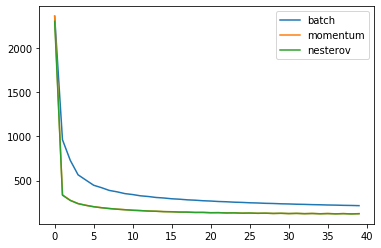

In [2]:
from __future__ import print_function, division
from builtins import range
# Note: you may need to update your version of future
# sudo pip install -U future

import numpy as np
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

from util import get_normalized_data, error_rate, cost, y2indicator
from mlp import forward, derivative_w2, derivative_w1, derivative_b2, derivative_b1


def main():
    # compare 3 scenarios:
    # 1. batch SGD
    # 2. batch SGD with momentum
    # 3. batch SGD with Nesterov momentum

    max_iter = 20 # make it 30 for sigmoid
    print_period = 50

    Xtrain, Xtest, Ytrain, Ytest = get_normalized_data()
    lr = 0.00004
    reg = 0.01

    Ytrain_ind = y2indicator(Ytrain)
    Ytest_ind = y2indicator(Ytest)

    N, D = Xtrain.shape
    batch_sz = 500
    n_batches = N // batch_sz

    M = 300
    K = 10
    W1 = np.random.randn(D, M) / np.sqrt(D)
    b1 = np.zeros(M)
    W2 = np.random.randn(M, K) / np.sqrt(M)
    b2 = np.zeros(K)

    # save initial weights
    W1_0 = W1.copy()
    b1_0 = b1.copy()
    W2_0 = W2.copy()
    b2_0 = b2.copy()

    # 1. batch
    losses_batch = []
    errors_batch = []
    for i in range(max_iter):
        for j in range(n_batches):
            Xbatch = Xtrain[j*batch_sz:(j*batch_sz + batch_sz),]
            Ybatch = Ytrain_ind[j*batch_sz:(j*batch_sz + batch_sz),]
            pYbatch, Z = forward(Xbatch, W1, b1, W2, b2)
            # print "first batch cost:", cost(pYbatch, Ybatch)

            # updates
            W2 -= lr*(derivative_w2(Z, Ybatch, pYbatch) + reg*W2)
            b2 -= lr*(derivative_b2(Ybatch, pYbatch) + reg*b2)
            W1 -= lr*(derivative_w1(Xbatch, Z, Ybatch, pYbatch, W2) + reg*W1)
            b1 -= lr*(derivative_b1(Z, Ybatch, pYbatch, W2) + reg*b1)

            if j % print_period == 0:
                pY, _ = forward(Xtest, W1, b1, W2, b2)
                l = cost(pY, Ytest_ind)
                losses_batch.append(l)
                print("Cost at iteration i=%d, j=%d: %.6f" % (i, j, l))

                e = error_rate(pY, Ytest)
                errors_batch.append(e)
                print("Error rate:", e)

    pY, _ = forward(Xtest, W1, b1, W2, b2)
    print("Final error rate:", error_rate(pY, Ytest))

    # 2. batch with momentum
    W1 = W1_0.copy()
    b1 = b1_0.copy()
    W2 = W2_0.copy()
    b2 = b2_0.copy()
    losses_momentum = []
    errors_momentum = []
    mu = 0.9
    dW2 = 0
    db2 = 0
    dW1 = 0
    db1 = 0
    for i in range(max_iter):
        for j in range(n_batches):
            Xbatch = Xtrain[j*batch_sz:(j*batch_sz + batch_sz),]
            Ybatch = Ytrain_ind[j*batch_sz:(j*batch_sz + batch_sz),]
            pYbatch, Z = forward(Xbatch, W1, b1, W2, b2)

            # gradients
            gW2 = derivative_w2(Z, Ybatch, pYbatch) + reg*W2
            gb2 = derivative_b2(Ybatch, pYbatch) + reg*b2
            gW1 = derivative_w1(Xbatch, Z, Ybatch, pYbatch, W2) + reg*W1
            gb1 = derivative_b1(Z, Ybatch, pYbatch, W2) + reg*b1

            # update velocities
            dW2 = mu*dW2 - lr*gW2
            db2 = mu*db2 - lr*gb2
            dW1 = mu*dW1 - lr*gW1
            db1 = mu*db1 - lr*gb1

            # updates
            W2 += dW2
            b2 += db2
            W1 += dW1
            b1 += db1

            if j % print_period == 0:
                pY, _ = forward(Xtest, W1, b1, W2, b2)
                l = cost(pY, Ytest_ind)
                losses_momentum.append(l)
                print("Cost at iteration i=%d, j=%d: %.6f" % (i, j, l))

                e = error_rate(pY, Ytest)
                errors_momentum.append(e)
                print("Error rate:", e)
    pY, _ = forward(Xtest, W1, b1, W2, b2)
    print("Final error rate:", error_rate(pY, Ytest))


    # 3. batch with Nesterov momentum
    W1 = W1_0.copy()
    b1 = b1_0.copy()
    W2 = W2_0.copy()
    b2 = b2_0.copy()

    losses_nesterov = []
    errors_nesterov = []

    mu = 0.9
    vW2 = 0
    vb2 = 0
    vW1 = 0
    vb1 = 0
    for i in range(max_iter):
        for j in range(n_batches):
            Xbatch = Xtrain[j*batch_sz:(j*batch_sz + batch_sz),]
            Ybatch = Ytrain_ind[j*batch_sz:(j*batch_sz + batch_sz),]
            pYbatch, Z = forward(Xbatch, W1, b1, W2, b2)

            # updates
            gW2 = derivative_w2(Z, Ybatch, pYbatch) + reg*W2
            gb2 = derivative_b2(Ybatch, pYbatch) + reg*b2
            gW1 = derivative_w1(Xbatch, Z, Ybatch, pYbatch, W2) + reg*W1
            gb1 = derivative_b1(Z, Ybatch, pYbatch, W2) + reg*b1

            # v update
            vW2 = mu*vW2 - lr*gW2
            vb2 = mu*vb2 - lr*gb2
            vW1 = mu*vW1 - lr*gW1
            vb1 = mu*vb1 - lr*gb1

            # param update
            W2 += mu*vW2 - lr*gW2
            b2 += mu*vb2 - lr*gb2
            W1 += mu*vW1 - lr*gW1
            b1 += mu*vb1 - lr*gb1

            if j % print_period == 0:
                pY, _ = forward(Xtest, W1, b1, W2, b2)
                l = cost(pY, Ytest_ind)
                losses_nesterov.append(l)
                print("Cost at iteration i=%d, j=%d: %.6f" % (i, j, l))

                e = error_rate(pY, Ytest)
                errors_nesterov.append(e)
                print("Error rate:", e)
    pY, _ = forward(Xtest, W1, b1, W2, b2)
    print("Final error rate:", error_rate(pY, Ytest))



    plt.plot(losses_batch, label="batch")
    plt.plot(losses_momentum, label="momentum")
    plt.plot(losses_nesterov, label="nesterov")
    plt.legend()
    plt.show()



if __name__ == '__main__':
    main()